# Feature Engineering

---
Outline:

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Load data

In [12]:
# Function to load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
    df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
    df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
    df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')
    return df

# Function to load price data
def load_price_data(file_path):
    price_df = pd.read_csv(file_path)
    price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
    return price_df

In [13]:
df = load_data('./data/clean_data_after_eda.csv')
price_df = load_price_data('data/price_data.csv')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January



The difference between off-peak prices in December and the preceding January is an important metric for understanding seasonal pricing trends in energy consumption. 

These features explain how the prices for off-peak energy usage change from January to December, which can be influenced by various factors such as demand fluctuations, changes in energy supply, and seasonal pricing strategies implemented by energy providers. 

Using these features, the model identify whether customers are experiencing higher or lower costs during the winter months compared to the beginning of the year. 


In [14]:
# Function to calculate off-peak price difference between December and January
def calculate_offpeak_diff(price_df):
    monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({
        'price_off_peak_var': 'mean', 
        'price_off_peak_fix': 'mean'
    }).reset_index()

    jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
    dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

    diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), 
                    jan_prices.drop(columns='price_date'), on='id')
    diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
    diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
    return diff[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']]

### mean price differences and maximum monthly differences

This section focuses on calculating the mean price differences and the maximum monthly differences for various pricing categories. 

First, we group the price data by 'id' and 'price_date' to compute the mean prices for off-peak, peak, and mid-peak periods, both in variable and fixed pricing formats. This aggregation allows us to analyze the average pricing trends over time for each customer (identified by 'id').

Next, we calculate the mean price differences between the different pricing categories (off-peak, peak, mid-peak) for both variable and fixed prices. This is done using nested loops to create new columns that represent the differences in mean prices between each pair of categories.

Finally, we aggregate these mean differences to find the maximum monthly differences for each pricing category combination. This provides insights into the most significant price fluctuations experienced by customers over the months, which can be crucial for understanding pricing strategies and customer behavior.

The resulting DataFrame contains the maximum monthly differences for each combination of pricing categories, allowing for a comprehensive analysis of pricing dynamics.

In [16]:
# Function to calculate mean price differences and maximum monthly differences
def calculate_mean_max_diff(price_df):
    mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
        'price_off_peak_var': 'mean', 
        'price_peak_var': 'mean', 
        'price_mid_peak_var': 'mean',
        'price_off_peak_fix': 'mean',
        'price_peak_fix': 'mean',
        'price_mid_peak_fix': 'mean'    
    }).reset_index()

    periods = ['off_peak', 'peak', 'mid_peak']
    for i in range(len(periods)):
        for j in range(i + 1, len(periods)):
            for var_type in ['var', 'fix']:
                col_name = f'{periods[i]}_{periods[j]}_{var_type}_mean_diff'
                mean_prices_by_month[col_name] = mean_prices_by_month[f'price_{periods[i]}_{var_type}'] - mean_prices_by_month[f'price_{periods[j]}_{var_type}']

    agg_dict = {f'{periods[i]}_{periods[j]}_{var_type}_mean_diff': 'max' for i in range(len(periods)) for j in range(i + 1, len(periods)) for var_type in ['var', 'fix']}
    max_diff_across_periods_months = mean_prices_by_month.groupby('id').agg(agg_dict).reset_index()

    max_diff_across_periods_months.columns = [
        'id',
        'off_peak_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_max_monthly_diff',
        'peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_max_monthly_diff'
    ]
    return max_diff_across_periods_months

Descriptions:

1. **`mean_prices_by_month`**: DataFrame containing the average prices per period (off-peak, peak, mid-peak) for each company and each price date.

2. **`off_peak_peak_var_mean_diff`**: Mean difference between off-peak and peak variable prices for each company and each price date.

3. **`off_peak_mid_peak_var_mean_diff`**: Mean difference between off-peak and mid-peak variable prices for each company and each price date.

4. **`peak_mid_peak_var_mean_diff`**: Mean difference between peak and mid-peak variable prices for each company and each price date.

5. **`off_peak_peak_fix_mean_diff`**: Mean difference between off-peak and peak fixed prices for each company and each price date.

6. **`off_peak_mid_peak_fix_mean_diff`**: Mean difference between off-peak and mid-peak fixed prices for each company and each price date.

7. **`peak_mid_peak_fix_mean_diff`**: Mean difference between peak and mid-peak fixed prices for each company and each price date.

8. **`max_diff_across_periods_months`**: DataFrame containing the maximum monthly differences across time periods for each company, with the following columns:
   - `id`: Company identifier.
   - `off_peak_peak_var_max_monthly_diff`: Maximum monthly difference between off-peak and peak variable prices.
   - `off_peak_mid_peak_var_max_monthly_diff`: Maximum monthly difference between off-peak and mid-peak variable prices.
   - `peak_mid_peak_var_max_monthly_diff`: Maximum monthly difference between peak and mid-peak variable prices.
   - `off_peak_peak_fix_max_monthly_diff`: Maximum monthly difference between off-peak and peak fixed prices.
   - `off_peak_mid_peak_fix_max_monthly_diff`: Maximum monthly difference between off-peak and mid-peak fixed prices.
   - `peak_mid_peak_fix_max_monthly_diff`: Maximum monthly difference between peak and mid-peak fixed prices.

In [17]:
offpeak_diff = calculate_offpeak_diff(price_df)
max_diff_across_periods_months = calculate_mean_max_diff(price_df)

In [18]:
df = pd.merge(df, offpeak_diff, on='id', how='left')
df = pd.merge(df, max_diff_across_periods_months, on='id', how='left')

### Tenure

In [19]:
# Function to calculate tenure
def calculate_tenure(df):
    df['tenure'] = ((df['date_end'] - df['date_activ']) / np.timedelta64(1, 'D') / 365).astype(int)
    return df

In [20]:
df = calculate_tenure(df)

### Categorizing channel sales

In [21]:
def categorize_low_counts(df, column_name, threshold=11, other_label='OTHER'):
    """Categorizes values in a DataFrame column with counts below a threshold.

    Args:
        df (pd.DataFrame): The DataFrame to work with.
        column_name (str): The name of the column to categorize.
        threshold (int, optional): Count threshold for grouping. Defaults to 11.
        other_label (str, optional): Label to use for grouped values. Defaults to 'OTHER'.

    Returns:
        pd.Series: A Series representing the categorized column.
    """

    value_counts = df[column_name].value_counts()
    common_values = value_counts[value_counts > threshold].index
    df[column_name] = df[column_name].where(df[column_name].isin(common_values), other_label)
    return df[column_name]

In [22]:
df['channel_sales'] = categorize_low_counts(df, 'channel_sales')

In [23]:
df['channel_sales'].value_counts()

channel_sales
foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
OTHER                                 16
Name: count, dtype: int64

Now we have 6 categories

### Creating Dummy Variables for channel_sales

In the next steps, we'll create dummy variables for the 'channel_sales' column. This process, known as one-hot encoding, converts categorical variables into a form that could be provided to ML algorithms to do a better job in prediction.

Here's what we're doing and why:

1. We're creating dummy variables for each category in 'channel_sales', except for the most common category.
2. We're also dropping the dummy variables for categories with very low counts.

The importance of leaving one category out:
When creating dummy variables, it's crucial to leave out one category (usually the most common one). This is done to avoid the "dummy variable trap," which is a scenario in which the independent variables are multicollinear - a scenario where two or more variables are highly correlated.

If we included all categories as dummy variables, we would have perfect multicollinearity because the sum of all dummy variables would always equal 1 for each observation. This would make the model unable to estimate the coefficients uniquely.

By leaving out one category, we make that category the reference category. The coefficients of the other dummy variables will then be interpreted relative to this reference category, avoiding the multicollinearity issue.

Additionally, dropping categories with very low counts helps to reduce noise in our model and prevent overfitting to rare categories that may not be representative of general patterns in the data.

In [24]:
def create_dummy_variables(df, column_name, prefix, low_count_categories=None):
    """
    Create dummy variables for a given column, dropping the most common category
    and optionally dropping categories with very low counts.

    Args:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to create dummies for.
        prefix (str): The prefix to use for the new dummy columns.
        low_count_categories (list, optional): List of categories to drop. Defaults to None.

    Returns:
        pd.DataFrame: The DataFrame with new dummy variables.
    """
    # Find the most common category
    most_common_category = df[column_name].value_counts().index[0]

    # Create dummy variables
    df = pd.get_dummies(df, columns=[column_name], prefix=prefix)

    # Drop the column for the most common category
    df = df.drop(columns=[f'{prefix}_{most_common_category}'])

    # Drop the columns for categories with very low counts if specified
    if low_count_categories:
        for category in low_count_categories:
            column_name = f'{prefix}_{category}'
            if column_name in df.columns:
                df = df.drop(columns=[column_name])

    return df

# Use the function to create dummy variables for channel_sales
low_count_categories = ['sddiedcslfslkckwlfkdpoeeailfpeds', 'epumfxlbckeskwekxbiuasklxalciiuu', 'fixdbufsefwooaasfcxdxadsiekoceaa']
df = create_dummy_variables(df, 'channel_sales', 'channel', low_count_categories)

# Display the first few rows to verify the changes
print(df[['channel_MISSING', 'channel_lmkebamcaaclubfxadlmueccxoimlema', 'channel_usilxuppasemubllopkaafesmlibmsdf', 'channel_ewpakwlliwisiwduibdlfmalxowmwpci', 'channel_OTHER']].head())


   channel_MISSING  channel_lmkebamcaaclubfxadlmueccxoimlema  \
0            False                                     False   
1             True                                     False   
2            False                                     False   
3            False                                      True   
4             True                                     False   

   channel_usilxuppasemubllopkaafesmlibmsdf  \
0                                     False   
1                                     False   
2                                     False   
3                                     False   
4                                     False   

   channel_ewpakwlliwisiwduibdlfmalxowmwpci  channel_OTHER  
0                                     False          False  
1                                     False          False  
2                                     False          False  
3                                     False          False  
4                          

### Creating Dummy Variables for origin_up

Similar to what we did with 'channel_sales', we'll now create dummy variables for the 'origin_up' column. This process involves:

1. Converting 'origin_up' to a categorical type.
2. Analyzing the frequency of each category.
3. Removing categories with very low frequency (less than 3 occurrences).
4. Creating dummy variables for the remaining categories, excluding the most common one.

The reasons for these steps are:

- Categorical type conversion ensures proper handling of the data.
- Removing low-frequency categories helps reduce noise and prevent overfitting.
- Excluding the most common category when creating dummies avoids the dummy variable trap.

This approach will allow us to effectively incorporate the 'origin_up' information into our model while maintaining statistical validity and model performance.


In [25]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')

# Let's see how many categories are within this column
df['origin_up'].value_counts()

origin_up
lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: count, dtype: int64

In [26]:
# Drop origin_up values where frequency is below 3
value_counts = df['origin_up'].value_counts()
low_frequency_categories = value_counts[value_counts < 3].index
df = df[~df['origin_up'].isin(low_frequency_categories)]


In [27]:
# Create dummy variables for origin_up, leaving out one category as a reference
# We'll leave out the most common category to avoid multicollinearity
most_common_origin = df['origin_up'].value_counts().index[0]

# Create dummy variables
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')

# Drop the column for the most common category
df = df.drop(columns=[f'origin_up_{most_common_origin}'])

# Display the first few rows to verify the changes
print(df[[col for col in df.columns if col.startswith('origin_up_')]].head())


   origin_up_MISSING  origin_up_ewxeelcelemmiwuafmddpobolfuxioce  \
0              False                                       False   
1              False                                       False   
2              False                                       False   
3              False                                       False   
4              False                                       False   

   origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws  \
0                                       False   
1                                        True   
2                                        True   
3                                        True   
4                                        True   

   origin_up_ldkssxwpmemidmecebumciepifcamkci  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

 

### Log Transformation of Numerical Features

The next step in our feature engineering process is to apply a logarithmic transformation 
to several numerical features in our dataset. This transformation is commonly used for 
the following reasons:

1. Normalization: It can help to normalize skewed data, making it more closely resemble 
   a normal distribution. This is often beneficial for many machine learning algorithms.

2. Handling of outliers: Log transformation can help to reduce the impact of outliers 
   by compressing the scale of very large values.

3. Linearization: In some cases, it can help to linearize relationships between variables, 
   which can be useful for certain types of models.

We'll be using a log base 10 transformation and adding 1 to each value before taking 
the log. This addition of 1 is to handle cases where the original value might be 0, 
as log(0) is undefined.

The features we'll transform are related to consumption and forecasts:
- cons_12m: consumption over the last 12 months
- cons_gas_12m: gas consumption over the last 12 months
- cons_last_month: consumption in the last month
- forecast_cons_12m: forecasted consumption for the next 12 months
- forecast_cons_year: forecasted yearly consumption
- forecast_meter_rent_12m: forecasted meter rent for 12 months
- imp_cons: imputed consumption (likely for missing values)

This transformation will be applied in the next code cell.


In [28]:
def apply_log10_transformation(df, columns):
    """
    Apply log10 transformation to specified columns in the dataframe.
    
    Args:
    df (pandas.DataFrame): The input dataframe
    columns (list): List of column names to transform
    
    Returns:
    pandas.DataFrame: The dataframe with transformed columns
    """
    for column in columns:
        df[column] = np.log10(df[column] + 1)
    return df

# List of columns to transform
columns_to_transform = [
    "cons_12m",
    "cons_gas_12m",
    "cons_last_month",
    "forecast_cons_12m",
    "forecast_cons_year",
    "forecast_meter_rent_12m",
    "imp_cons"
]

# Apply log10 transformation
df = apply_log10_transformation(df, columns_to_transform)

C:\Users\ASUS TUF\AppData\Local\Temp\ipykernel_28352\2555972264.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


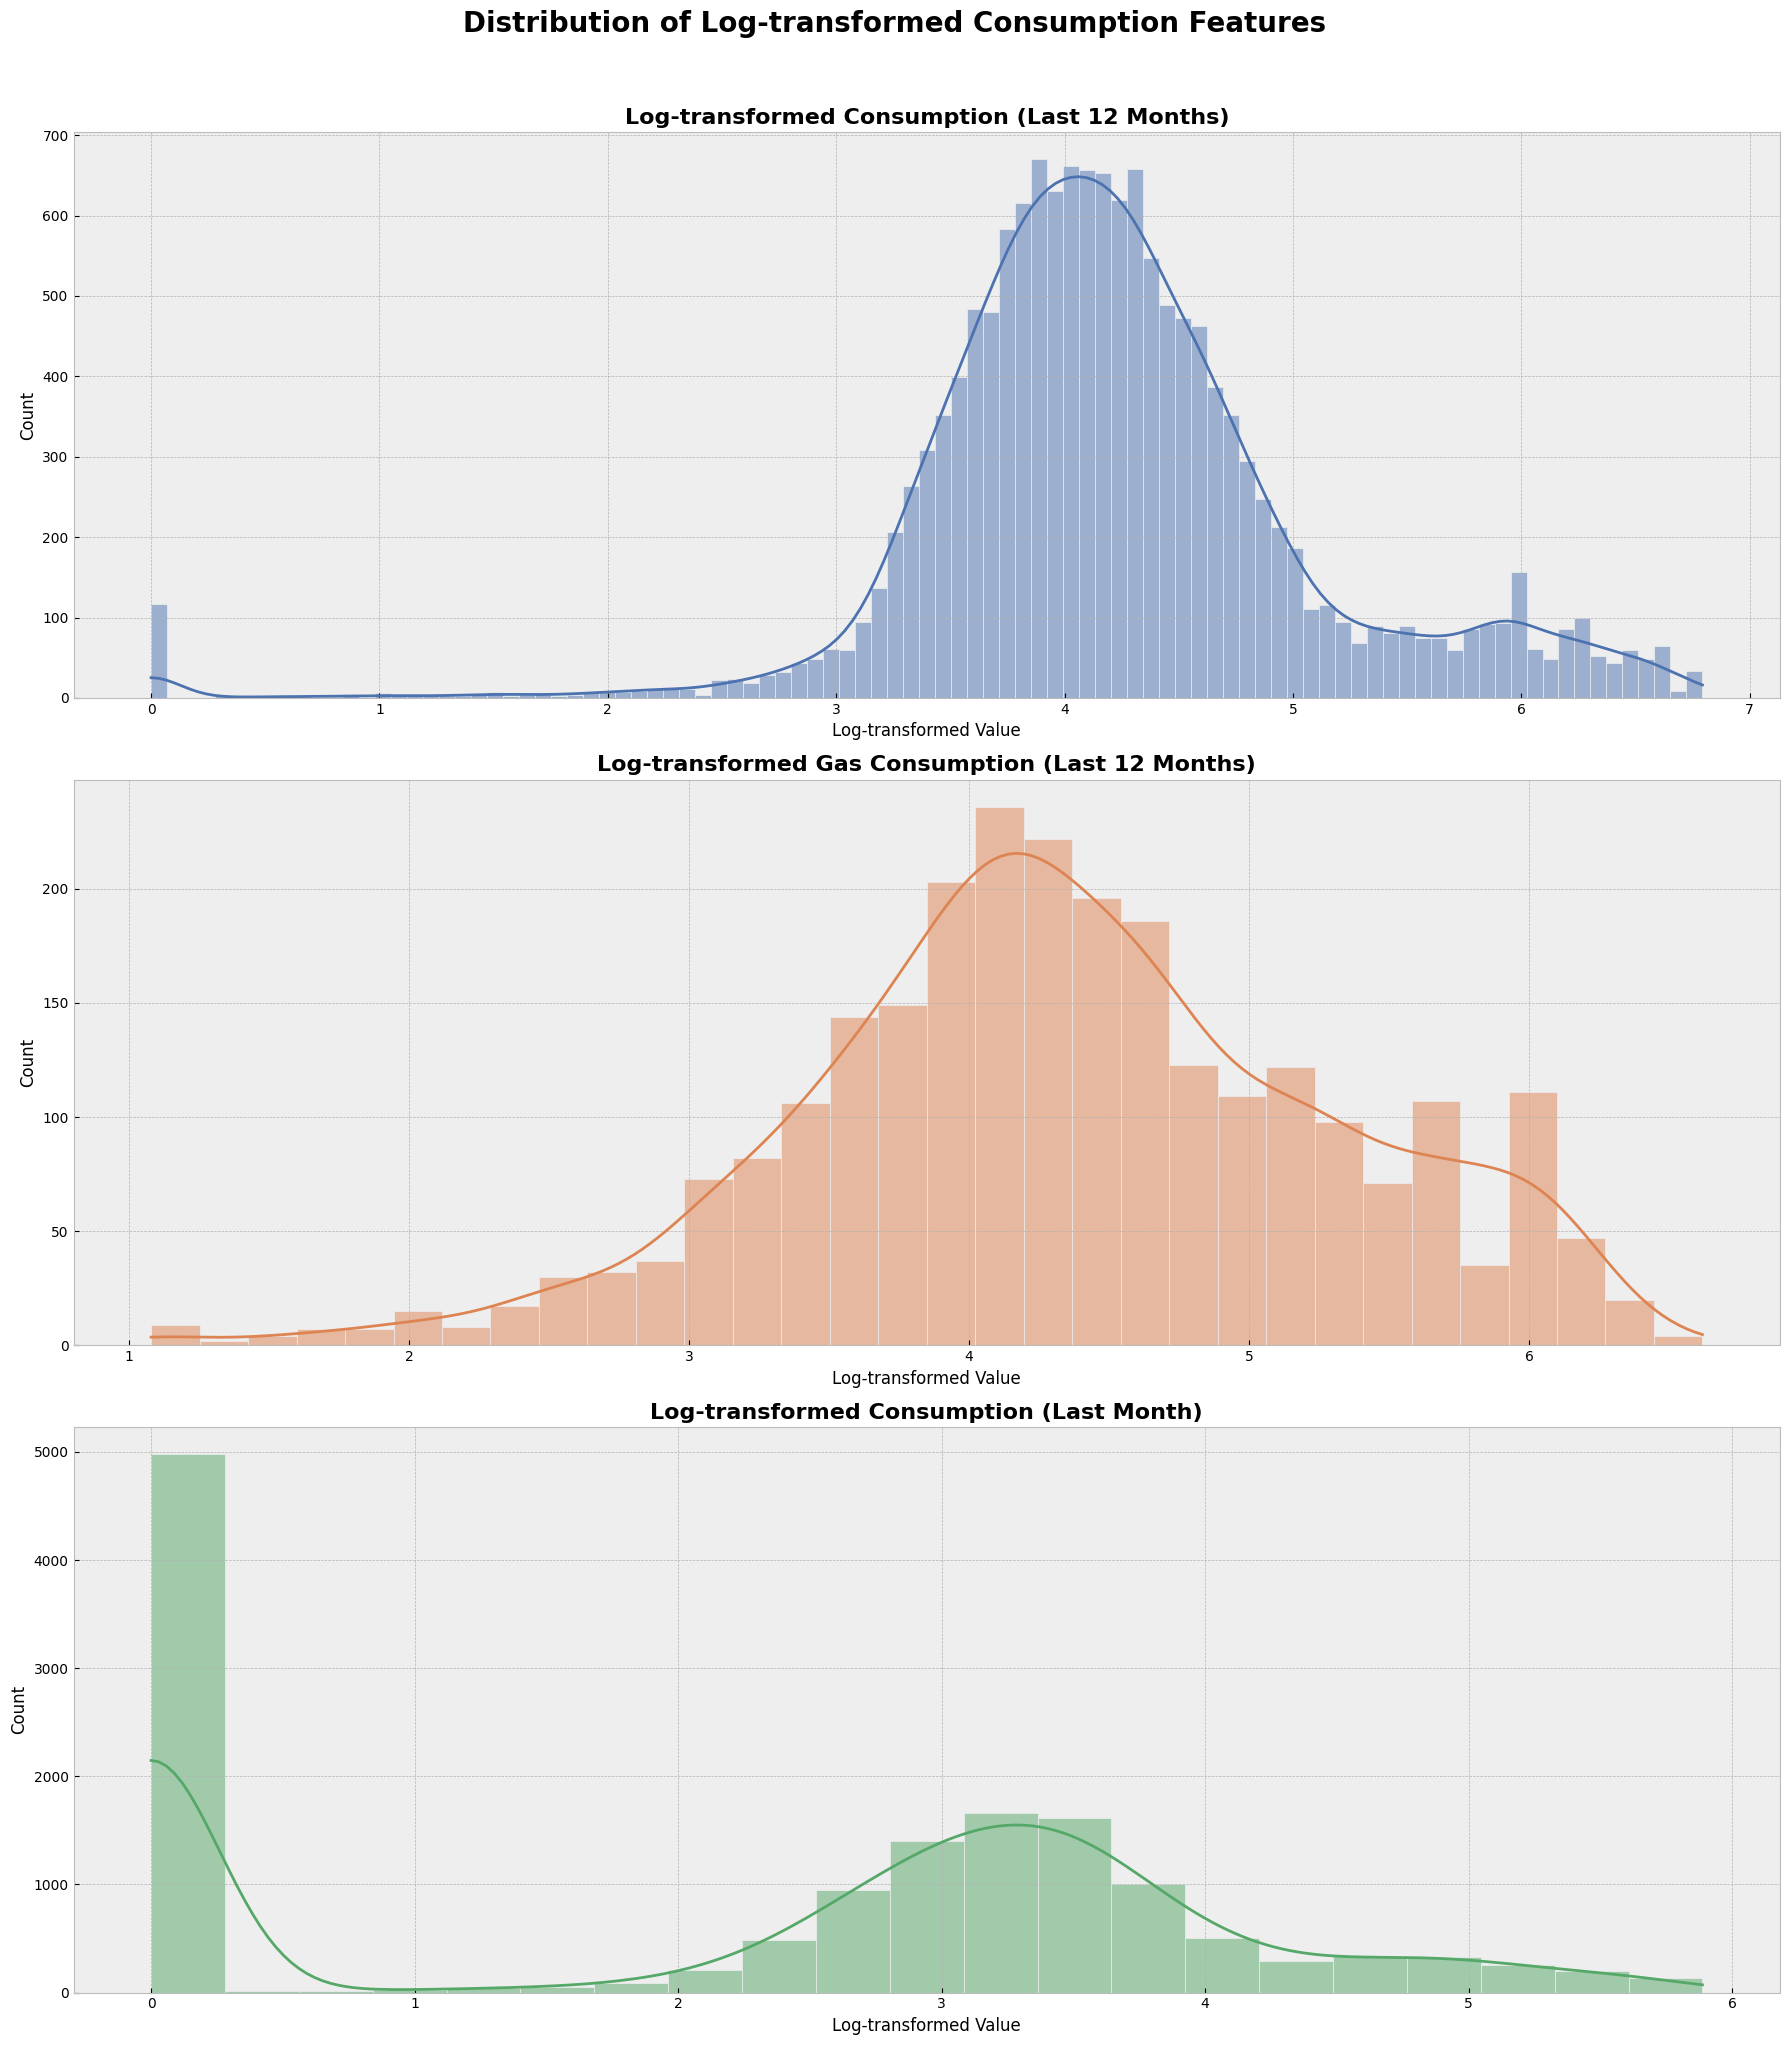

In [32]:
# Set up the plot style
plt.style.use('bmh')
sns.set_palette("deep")

# Create subplots with better spacing
fig, axs = plt.subplots(nrows=3, figsize=(18, 20), constrained_layout=True)

# Plot histograms with improved styling
for i, (column, title) in enumerate([
    ("cons_12m", "Log-transformed Consumption (Last 12 Months)"),
    ("cons_gas_12m", "Log-transformed Gas Consumption (Last 12 Months)"),
    ("cons_last_month", "Log-transformed Consumption (Last Month)")
]):
    data = df[column].dropna()
    if column == "cons_gas_12m":
        data = data[data != 0]  # Remove zero values before log transformation
    
    sns.histplot(data, kde=True, ax=axs[i], color=sns.color_palette("deep")[i])
    axs[i].set_title(title, fontsize=16, fontweight='bold')
    axs[i].set_xlabel("Log-transformed Value", fontsize=12)
    axs[i].set_ylabel("Count", fontsize=12)
    axs[i].tick_params(labelsize=10)

# Add an overall title
fig.suptitle("Distribution of Log-transformed Consumption Features", fontsize=20, fontweight='bold', y=1.02)

# Adjust layout and display
plt.tight_layout()
plt.show()

# 4. Feature Selection: Correlation Analysis and Feature Removal

In this step, we will perform feature selection and dimensionality reduction to improve our model's performance and reduce overfitting. This process involves:

1. Analyzing the correlation matrix to identify highly correlated features.
2. Removing redundant features based on their correlation.

The correlation heatmap and the list of highly correlated feature pairs will help us make informed decisions about which features to keep or remove.


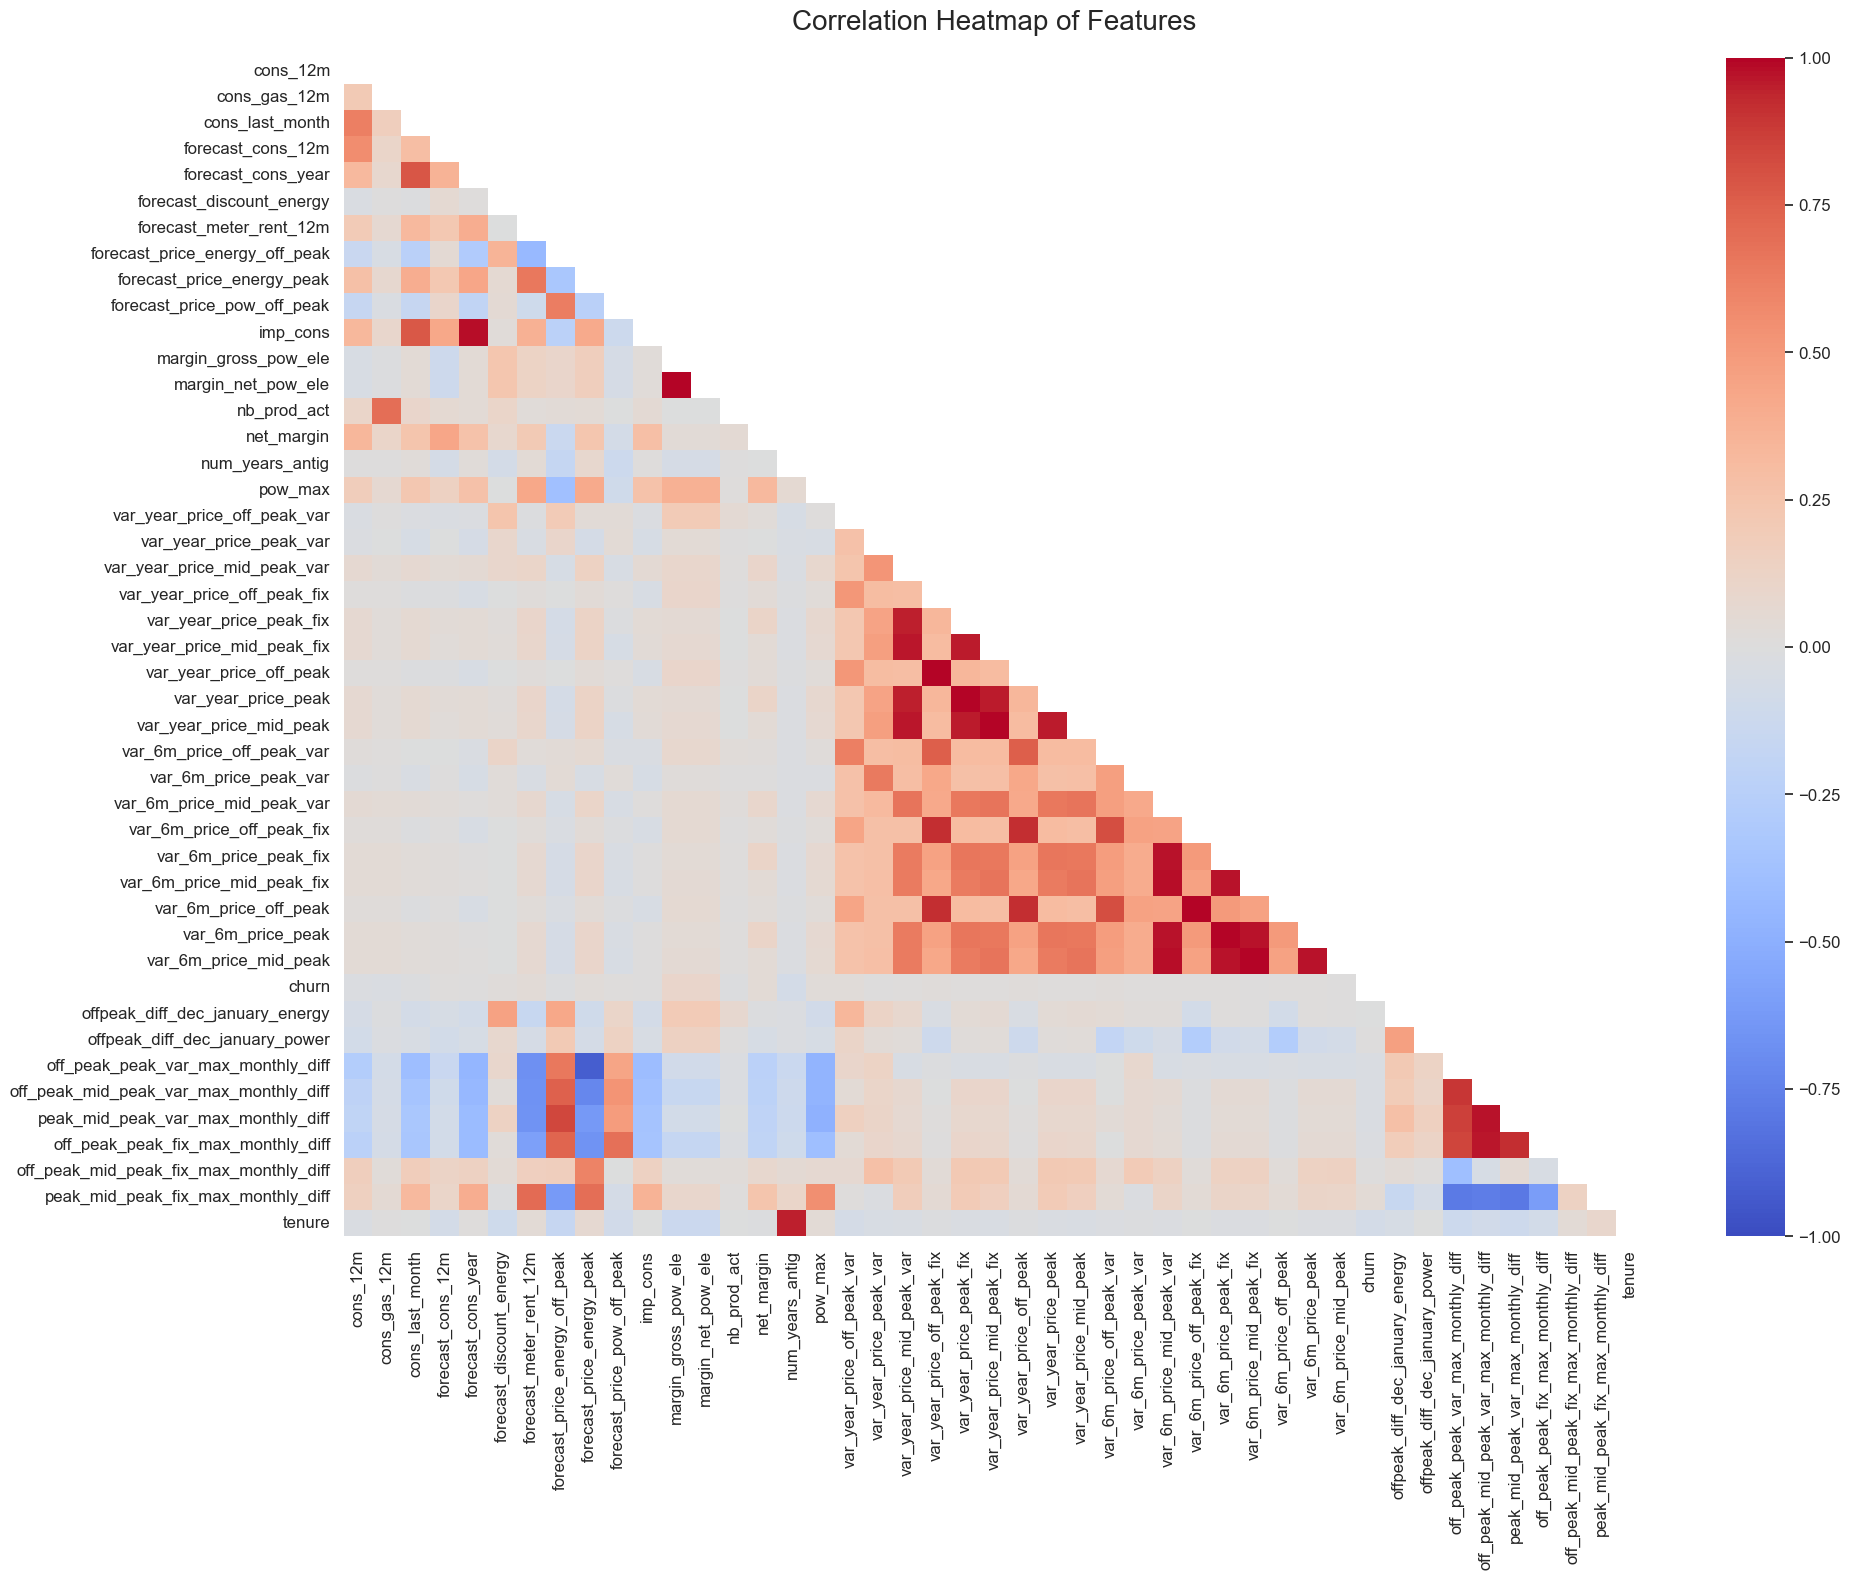

Highly correlated feature pairs (correlation > 0.8):
var_6m_price_mid_peak - var_6m_price_mid_peak_fix: 1.00
var_year_price_mid_peak - var_year_price_mid_peak_fix: 1.00
var_6m_price_off_peak - var_6m_price_off_peak_fix: 1.00
var_year_price_peak - var_year_price_peak_fix: 1.00
var_6m_price_peak - var_6m_price_peak_fix: 1.00
var_year_price_off_peak - var_year_price_off_peak_fix: 1.00
margin_net_pow_ele - margin_gross_pow_ele: 1.00
imp_cons - forecast_cons_year: 0.98
var_6m_price_mid_peak - var_6m_price_mid_peak_var: 0.98
var_6m_price_mid_peak_fix - var_6m_price_mid_peak_var: 0.98
var_6m_price_mid_peak - var_6m_price_peak: 0.97
var_6m_price_mid_peak - var_6m_price_peak_fix: 0.97
var_6m_price_peak - var_6m_price_mid_peak_fix: 0.97
var_6m_price_mid_peak_fix - var_6m_price_peak_fix: 0.97
var_6m_price_peak - var_6m_price_mid_peak_var: 0.97
var_6m_price_peak_fix - var_6m_price_mid_peak_var: 0.97
peak_mid_peak_var_max_monthly_diff - off_peak_mid_peak_var_max_monthly_diff: 0.97
off_peak_peak_fix

In [34]:
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the plot style
plt.figure(figsize=(20, 16))
sns.set(font_scale=1.1)
sns.set_style("white")

# Create a heatmap of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap="coolwarm", vmin=-1, vmax=1, center=0)

plt.title("Correlation Heatmap of Features", fontsize=20, pad=20)
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Sort pairs by correlation strength
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("Highly correlated feature pairs (correlation > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")

Now, we'll drop one for each highly correlated feature pair.

Number of features dropped: 19
Remaining features: 42

Dropped features:
off_peak_mid_peak_var_max_monthly_diff
var_6m_price_off_peak_var
forecast_price_energy_peak
var_year_price_mid_peak_fix
var_year_price_mid_peak_var
off_peak_peak_var_max_monthly_diff
var_year_price_peak_fix
peak_mid_peak_var_max_monthly_diff
var_year_price_off_peak
var_6m_price_mid_peak_fix
var_6m_price_mid_peak_var
forecast_cons_year
var_6m_price_peak
var_6m_price_off_peak_fix
margin_gross_pow_ele
var_6m_price_peak_fix
num_years_antig
var_year_price_off_peak_fix
var_year_price_peak


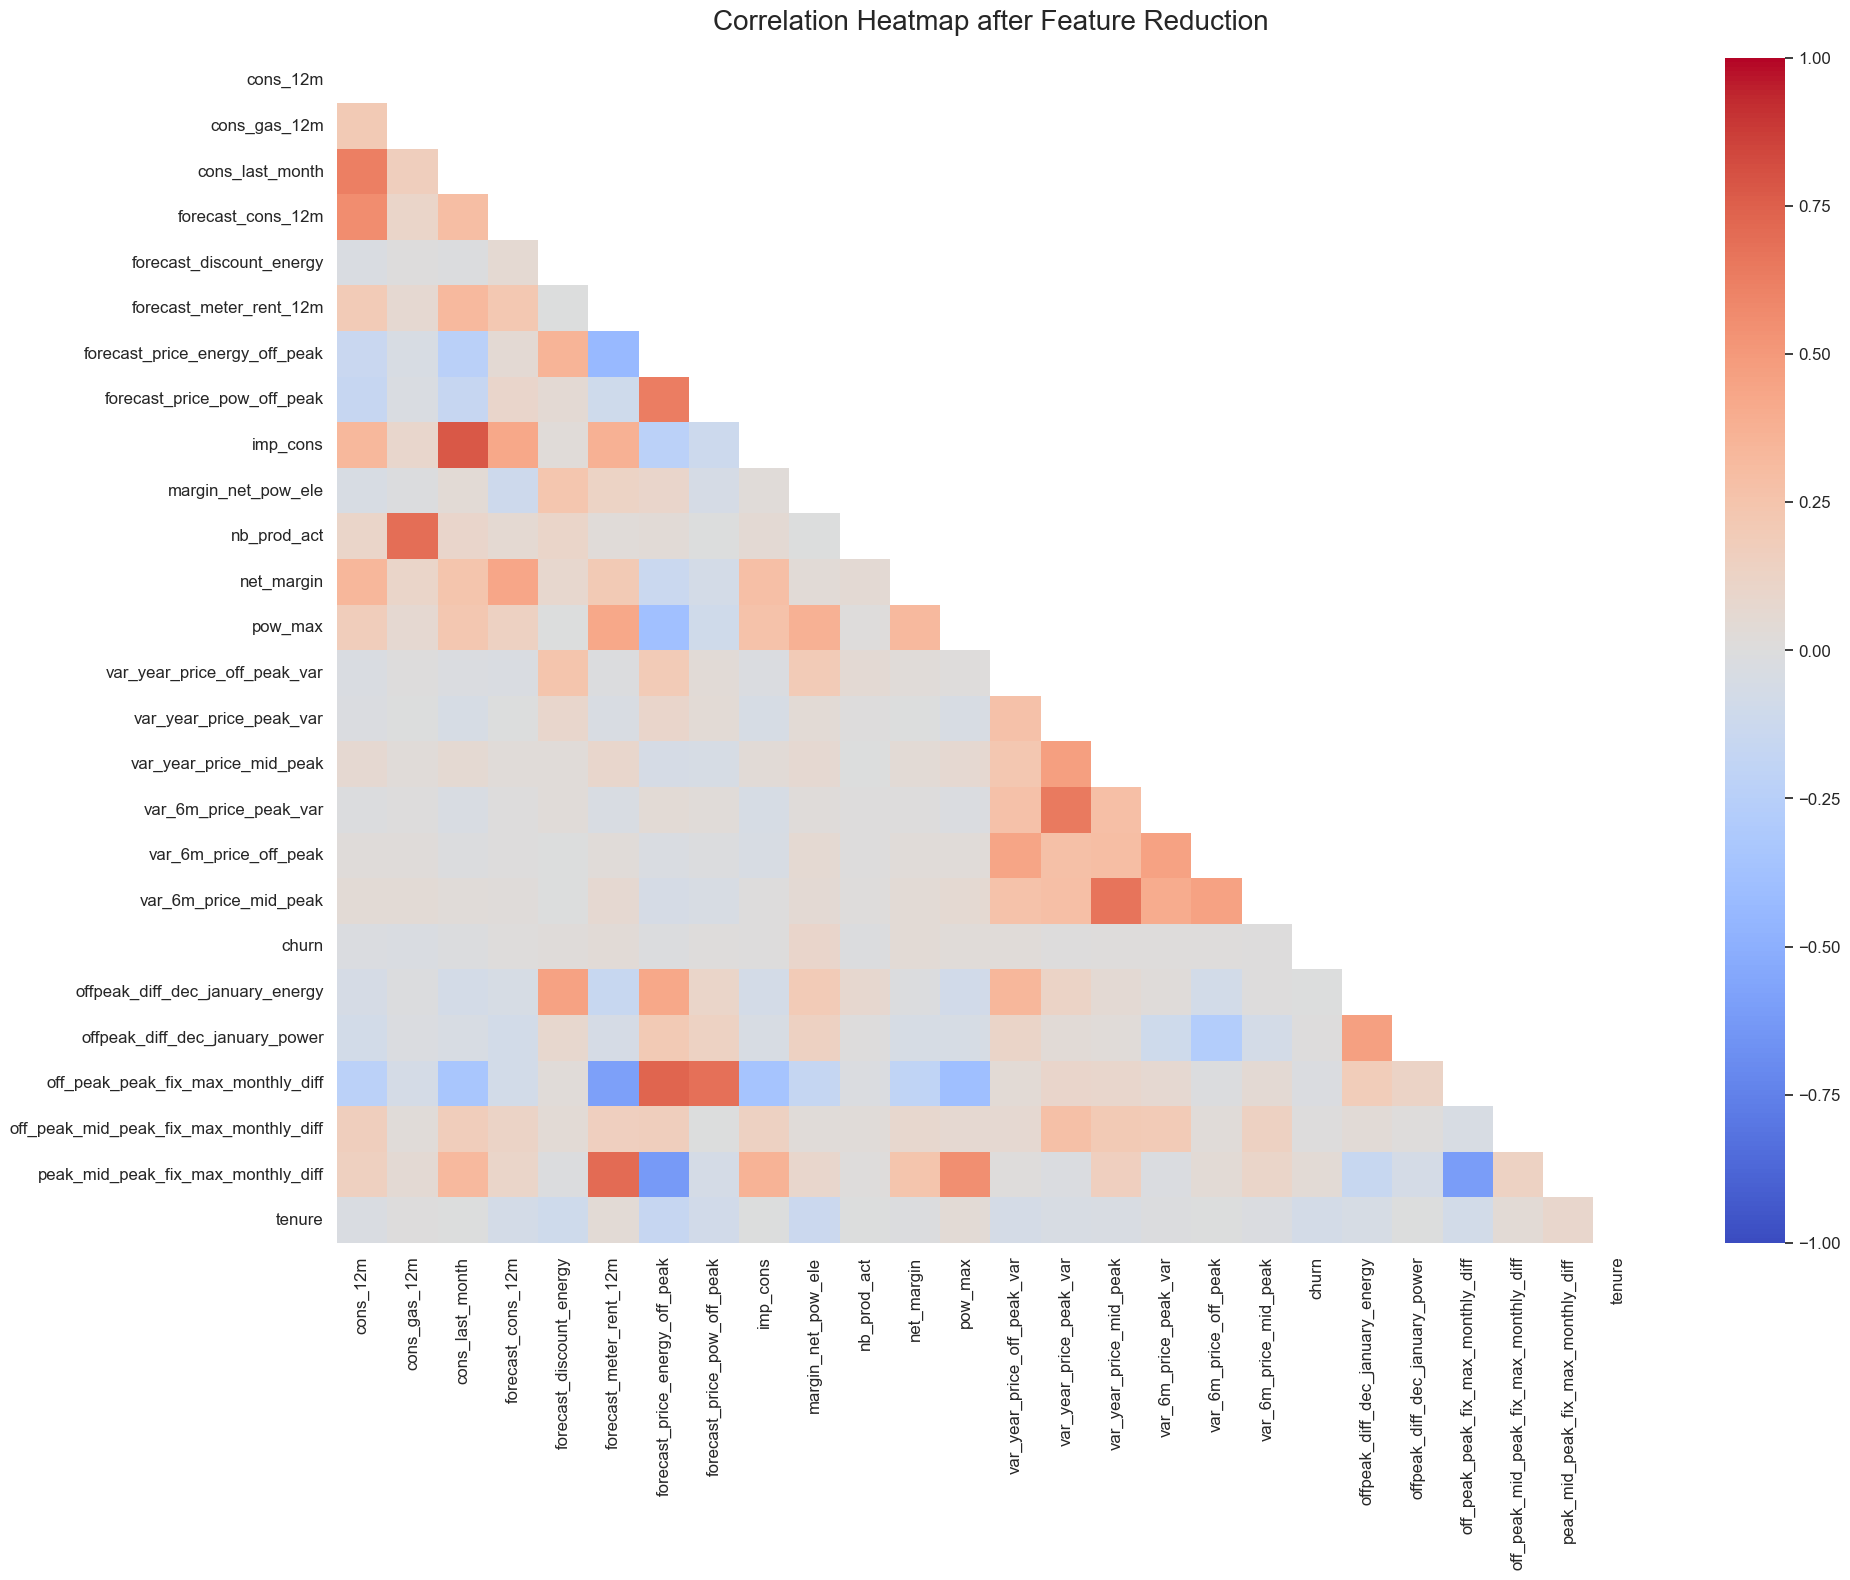

In [35]:
def reduce_correlated_features(df, high_corr_pairs, correlation_threshold=0.8):
    # Create a set to store features to drop
    features_to_drop = set()

    # Iterate through highly correlated pairs
    for pair in high_corr_pairs:
        # If neither feature in the pair has been marked for dropping, drop the second one
        if pair[0] not in features_to_drop and pair[1] not in features_to_drop:
            features_to_drop.add(pair[1])

    # Drop the identified features
    df_reduced = df.drop(columns=list(features_to_drop))

    print(f"Number of features dropped: {len(features_to_drop)}")
    print(f"Remaining features: {df_reduced.shape[1]}")

    # Display the list of dropped features
    print("\nDropped features:")
    for feature in features_to_drop:
        print(feature)

    # Update the numeric_df with the reduced feature set
    numeric_df_reduced = df_reduced.select_dtypes(include=[np.number])

    # Recalculate the correlation matrix
    corr_matrix_reduced = numeric_df_reduced.corr()

    return df_reduced, corr_matrix_reduced

# Call the function
df_reduced, corr_matrix_reduced = reduce_correlated_features(df, high_corr_pairs)

# Visualize the new correlation matrix
plt.figure(figsize=(20, 16))
sns.set(font_scale=1.1)
sns.set_style("white")

mask = np.triu(np.ones_like(corr_matrix_reduced, dtype=bool))
sns.heatmap(corr_matrix_reduced, mask=mask, annot=False, cmap="coolwarm", vmin=-1, vmax=1, center=0)

plt.title("Correlation Heatmap after Feature Reduction", fontsize=20, pad=20)
plt.tight_layout()
plt.show()
